In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import rnn
import pickle
from Bio import SeqIO
import os
#import main

Using TensorFlow backend.
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Test the `RNNModel`

In [5]:
base_path = '/Users/venkatesh-sivaraman/Documents/School/MIT/6-047/proj/hicmotif/data/'

In [7]:
with open(os.path.join(base_path, 'epigenomic_tracks', 'GM12878.pickle'), 'rb') as file:
    id, data = pickle.load(file)

In [8]:
seq = None
for record in SeqIO.parse(os.path.join(base_path, 'loop_sequences_GM12878.fasta'), 'fasta'):
    print(record.id.replace('chr', ''), id)
    if record.id.replace('chr', '') != id: continue
    seq = models.Sequence(id, str(record.seq), data)
    break

print(len(seq.seq))

10:100225000:100425000 10:100225000:100425000
200000


In [33]:
seq_length = 100
num_examples = len(seq.seq) // seq_length
seq_array = seq.to_array()

# Generate num_examples subsequences of length seq_length with replacement
X = np.zeros((num_examples, seq_array.shape[0], seq_length))
for i in range(num_examples):
    start = np.random.randint(0, seq_array.shape[1] - seq_length)
    X[i] = seq_array[:,start:start + seq_length]

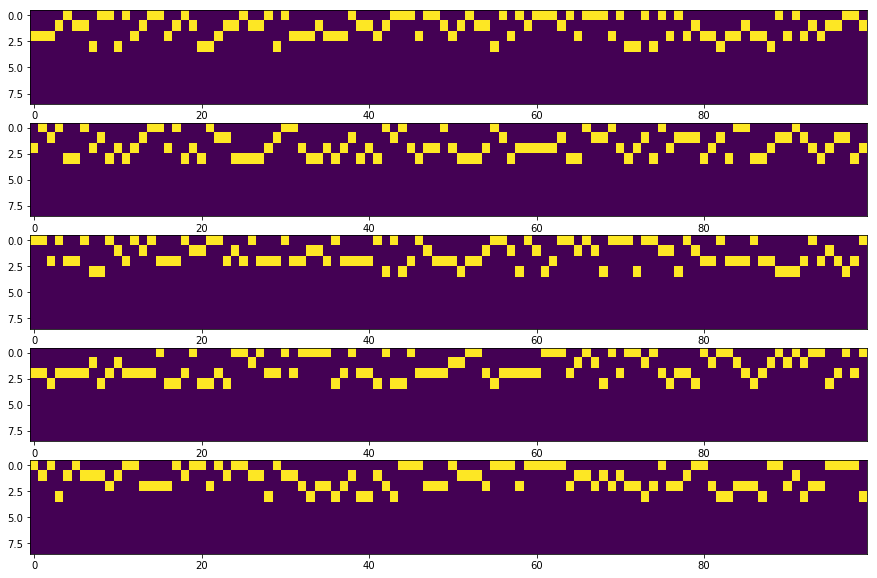

In [35]:
# Look at some of the training examples
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.imshow(X[i], aspect='auto')
plt.show()

In [44]:
#Generate random y
n_labels = 3
Y_numerical = np.random.randint(0, n_labels, size=X.shape[0])
Y = np.zeros((X.shape[0], n_labels))
for i in range(Y_numerical.shape[0]):
    Y[i,Y_numerical[i]] = 1

In [48]:
model = rnn.RNNModel(sequence_length=seq_length, n_features=X.shape[1], n_labels=n_labels)
model.create()

In [51]:
model.train(X, Y, epochs=5)

Epoch 1/5
2000/2000 [==============================] - 1s 477us/step - loss: 1.0993 - acc: 0.3355
Epoch 2/5
2000/2000 [==============================] - 1s 458us/step - loss: 1.0978 - acc: 0.3335
Epoch 3/5
2000/2000 [==============================] - 1s 459us/step - loss: 1.0978 - acc: 0.3370
Epoch 4/5
2000/2000 [==============================] - 1s 454us/step - loss: 1.0963 - acc: 0.3710
Epoch 5/5
2000/2000 [==============================] - 1s 451us/step - loss: 1.0954 - acc: 0.3775


In [ ]:
model.model